In [41]:
#| echo: false
#| warning: false

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import glmnet as glm
import statsmodels.api as sm
import statsmodels.formula.api as smf

import tqdm
import itertools

%matplotlib inline
import matplotlib_inline.backend_inline

sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

## 6.1 Lab: Linear Model Selection and Regularization

### 6.1.1 Subset selection methods

In [100]:
# useful link: https://xavierbourretsicotte.github.io/subset_selection.html#Best-subset-selection

Load `Hitters` data set

In [31]:
df_hitters = pd.read_csv("../Data/Hitters.csv")

In [32]:
df_hitters.rename(columns = {'Unnamed: 0': 'Player'}, inplace = True)
df_hitters.set_index('Player', inplace = True)

In [21]:
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [22]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

There are 59 missing observations in `Salary` column. Let's drop them

In [33]:
df_hitters.dropna(inplace = True)
df_hitters.shape

(263, 20)

Create dummy variables `League_N`, `Division_W`, `NewLeague_N` 

In [34]:
dummy_vars = pd.get_dummies(df_hitters[['League', 'Division', 'NewLeague']])

In [35]:
dummy_vars.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
Player,,,,,,
-Alan Ashby,0,1,0,1,0,1
-Alvin Davis,1,0,0,1,1,0
-Andre Dawson,0,1,1,0,0,1
-Andres Galarraga,0,1,1,0,0,1
-Alfredo Griffin,1,0,0,1,1,0


In [36]:
df_hitters.drop(["League", "Division", "NewLeague"], axis = 1, inplace = True)
df_hitters = pd.concat([df_hitters, dummy_vars[["League_N", "Division_W", "NewLeague_N"]]], axis = 1)

In [37]:
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


Define a helper function for fitting linear regression

In [38]:
def fit_linear_reg(X,Y):
    """
    Fit a linear regression model and return the RSS and R-squared

    X: a pandas dataframe of predictors
    Y: a pandas series of the response variable

    Returns: RSS, R_squared
    """

    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X, Y)
    RSS = mean_squared_error(Y, model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X, Y)
    return RSS, R_squared

In [42]:
# Initialization variables
Y = df_hitters['Salary']
X = df_hitters.drop(columns = 'Salary', axis = 1)
k = df_hitters.shape[1]
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

# Looping over k = 1 to k = 20 features in X
for k in tqdm.notebook.trange(1,len(X.columns) + 1, desc = 'Loop...'):

    # Looping over all possible combinations: from 20 choose k
    for combo in itertools.combinations(X.columns, k):
        tmp_result = fit_linear_reg(X[list(combo)], Y)
        RSS_list.append(tmp_result[0])
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

# Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

Loop...:   0%|          | 0/19 [00:00<?, ?it/s]

Finding the best subsets for each number of features

In [54]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_max.sort_values(by = ['R_squared', 'numb_features'], ascending = [False, False]).head(19))

,numb_features,RSS,R_squared,features
524286,19,2.420070e+07,0.546116,"(AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ..."
524276,18,2.420184e+07,0.546095,"(AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ..."
524171,17,2.420945e+07,0.545952,"(AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,..."
523383,16,2.421938e+07,0.545766,"(AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,..."
520508,15,2.423518e+07,0.545469,"(AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit..."
510276,14,2.424866e+07,0.545216,"(AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun..."
491152,13,2.428915e+07,0.544457,"(AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI..."
445635,12,2.433323e+07,0.543630,"(AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI..."
377918,11,2.438735e+07,0.542615,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."
284754,10,2.450040e+07,0.540495,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."


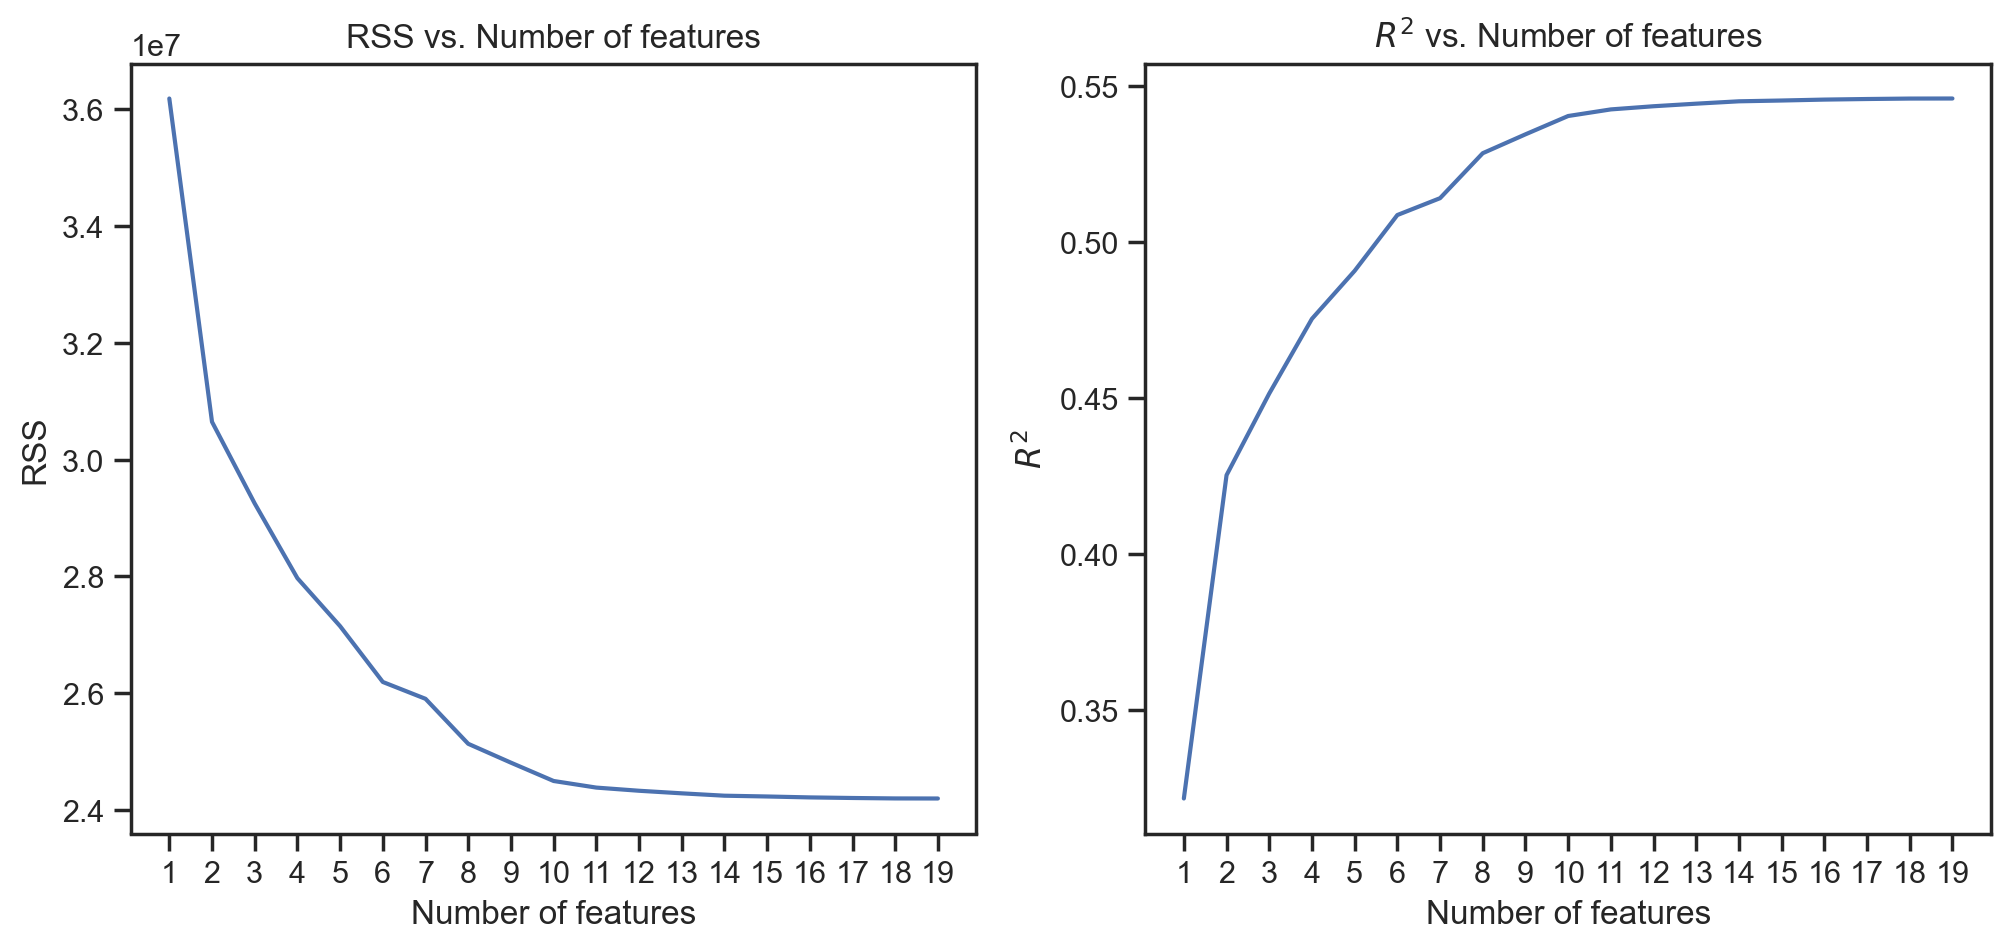

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.lineplot(x = 'numb_features', y = 'RSS', data = df_min, ax = ax1, label = 'RSS')
sns.lineplot(x = 'numb_features', y = 'R_squared', data = df_max, ax = ax2, label = 'R_squared')

for ax in [ax1, ax2]:
    ax.set_xticks(range(1,20))
    ax.set_xlabel('Number of features')
    ax.get_legend().remove()

ax1.set_title('RSS vs. Number of features')
ax2.set_title('$R^2$ vs. Number of features')
ax2.set_ylabel('$R^2$')

plt.show()

Computing the $C_p$, $AIC$, $BIC$ and $R^2$ adjusted

In [81]:
#Initializing useful variables
m = len(df_hitters)
hat_sigma_squared = (1/(m - k -1)) * min(df['RSS'])

#Computing
df['C_p'] = (1/m) * (df['RSS'] + 2 * df['numb_features'] * hat_sigma_squared )
df['AIC'] = (1/(m*hat_sigma_squared)) * (df['RSS'] + 2 * df['numb_features'] * hat_sigma_squared )
df['BIC'] = (1/(m*hat_sigma_squared)) * (df['RSS'] +  np.log(m) * df['numb_features'] * hat_sigma_squared )
df['R_squared_adj'] = 1 - ( (1 - df['R_squared'])*(m-1)/(m-df['numb_features'] -1))

In [88]:
display(df.sort_values(by = ['R_squared_adj', 'AIC'], ascending = [False, True]).head(10))

,numb_features,RSS,R_squared,features,C_p,AIC,BIC,R_squared_adj
377918,11,2.438735e+07,0.542615,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",101058.383602,1.014730,1.164136,0.522571
284754,10,2.450040e+07,0.540495,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",100730.907458,1.011442,1.147266,0.522261
372127,11,2.442450e+07,0.541918,"(AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",101199.662412,1.016149,1.165555,0.521843
445635,12,2.433323e+07,0.543630,"(AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",101609.980713,1.020269,1.183257,0.521724
449201,12,2.433822e+07,0.543537,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",101628.927611,1.020459,1.183447,0.521627
377920,11,2.443569e+07,0.541709,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",101242.203859,1.016576,1.165982,0.521624
449132,12,2.436467e+07,0.543041,"(AtBat, Hits, Walks, CAtBat, CHits, CRuns, CRB...",101729.511018,1.021469,1.184457,0.521107
377749,11,2.446284e+07,0.541199,"(AtBat, Hits, Walks, CAtBat, CHits, CRuns, CRB...",101345.428684,1.017613,1.167018,0.521093
377916,11,2.446514e+07,0.541156,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",101354.173241,1.017701,1.167106,0.521048
445637,12,2.437834e+07,0.542784,"(AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",101781.479110,1.021991,1.184979,0.520838


Show the best model

In [98]:
df_best = df.loc[df['AIC'].idxmin()]
display(df_best)

numb_features                                                   10
RSS                                                 24500401.53774
R_squared                                                 0.540495
features         (AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...
C_p                                                  100730.907458
AIC                                                       1.011442
BIC                                                       1.147266
R_squared_adj                                             0.522261
Name: 284754, dtype: object

Re-estimate the best model

In [119]:
my_formula = 'Salary ~ ' + ' + '.join(df_best[3])
mod1 = smf.ols(formula = my_formula, data = df_hitters).fit()

In [116]:
print(mod1.summary().tables[0])
print(mod1.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     29.64
Date:                Tue, 24 Jan 2023   Prob (F-statistic):           2.80e-37
Time:                        20:51:49   Log-Likelihood:                -1877.8
No. Observations:                 263   AIC:                             3778.
Df Residuals:                     252   BIC:                             3817.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    162.5354     66.908      2.429      0.0

**End of Linear Model Selection and Regularization Methods practice code**